# cdp run_30min_ext

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [2]:
site = 'cdp'
site_longname = 'Col de Porte, France'
y_start = 1994
y_end = 1994

labels = ['test_30min_ext']

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [3]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref_30min_ext.nc')

In [4]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [5]:
for i in range(len(labels)):
    ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

Text(0.5, 0.98, 'Col de Porte, France')

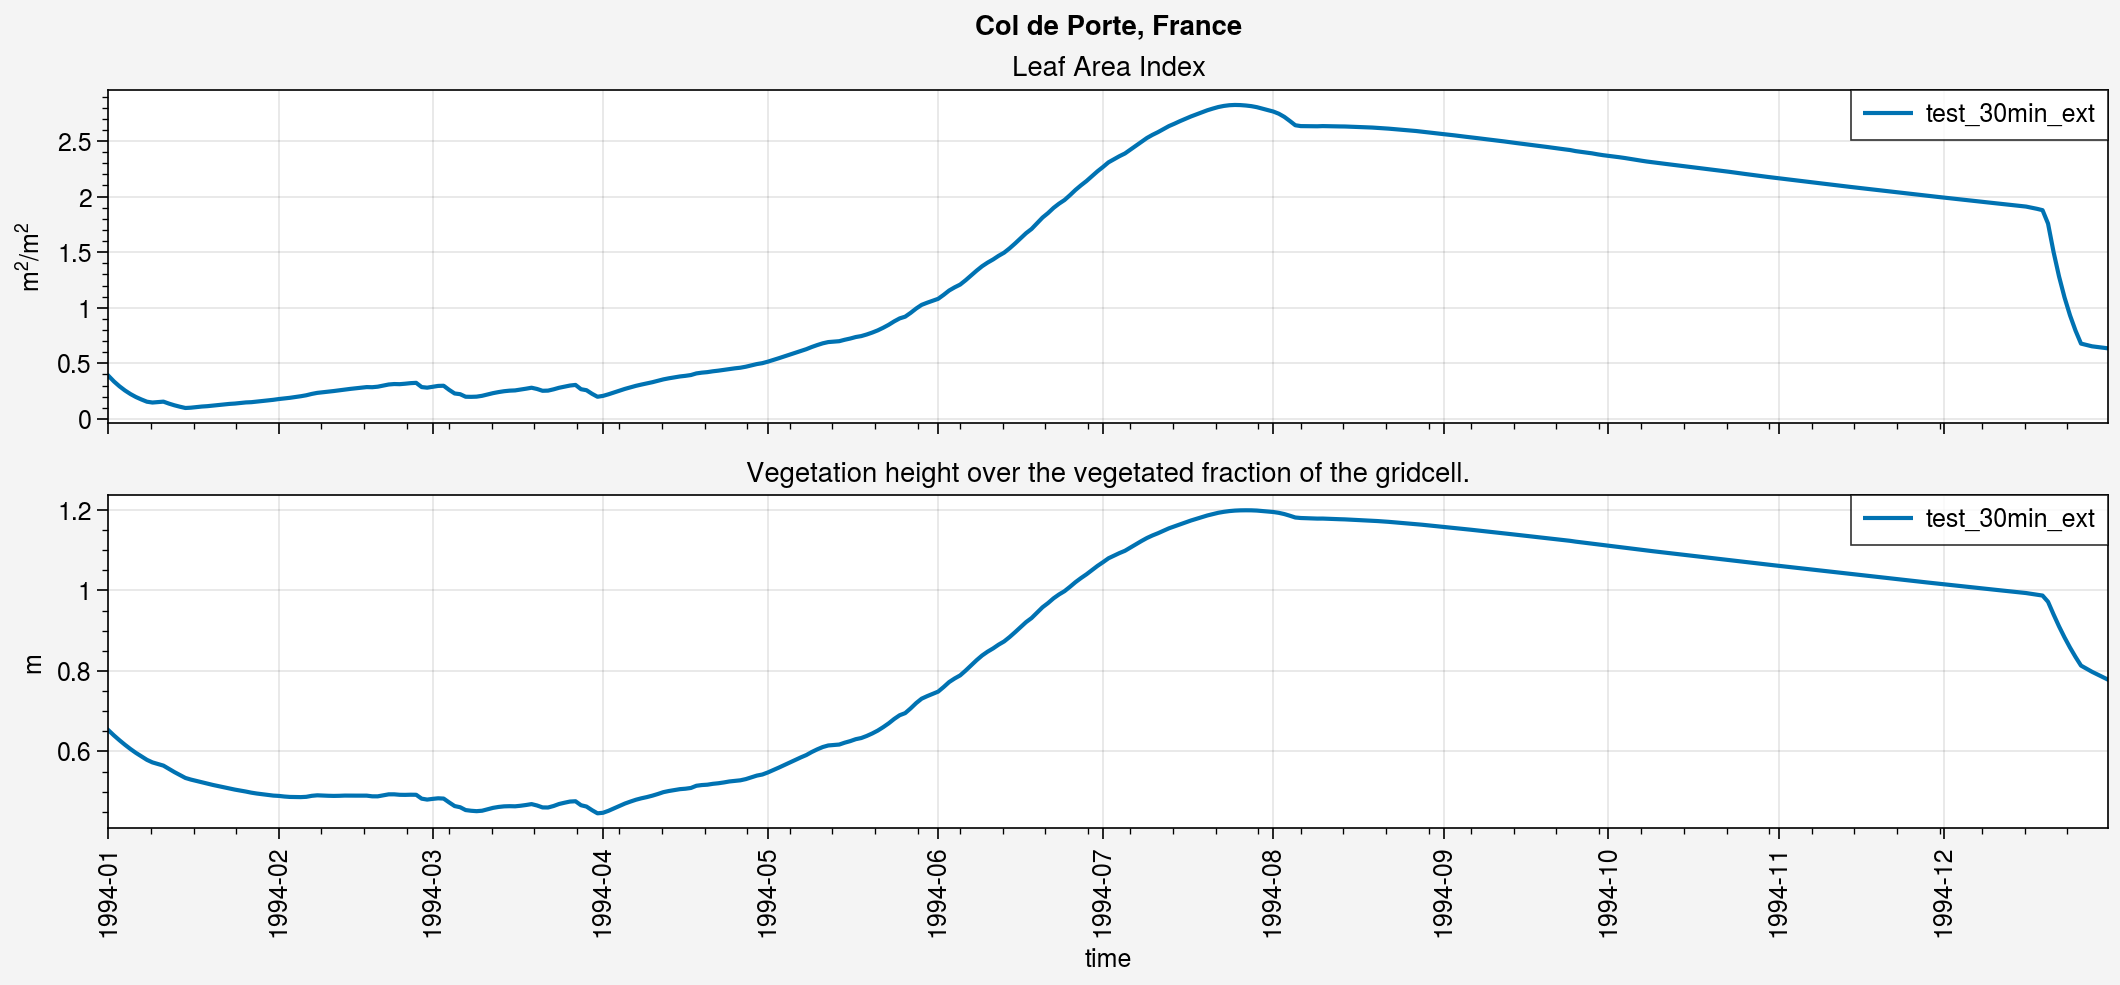

In [6]:
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

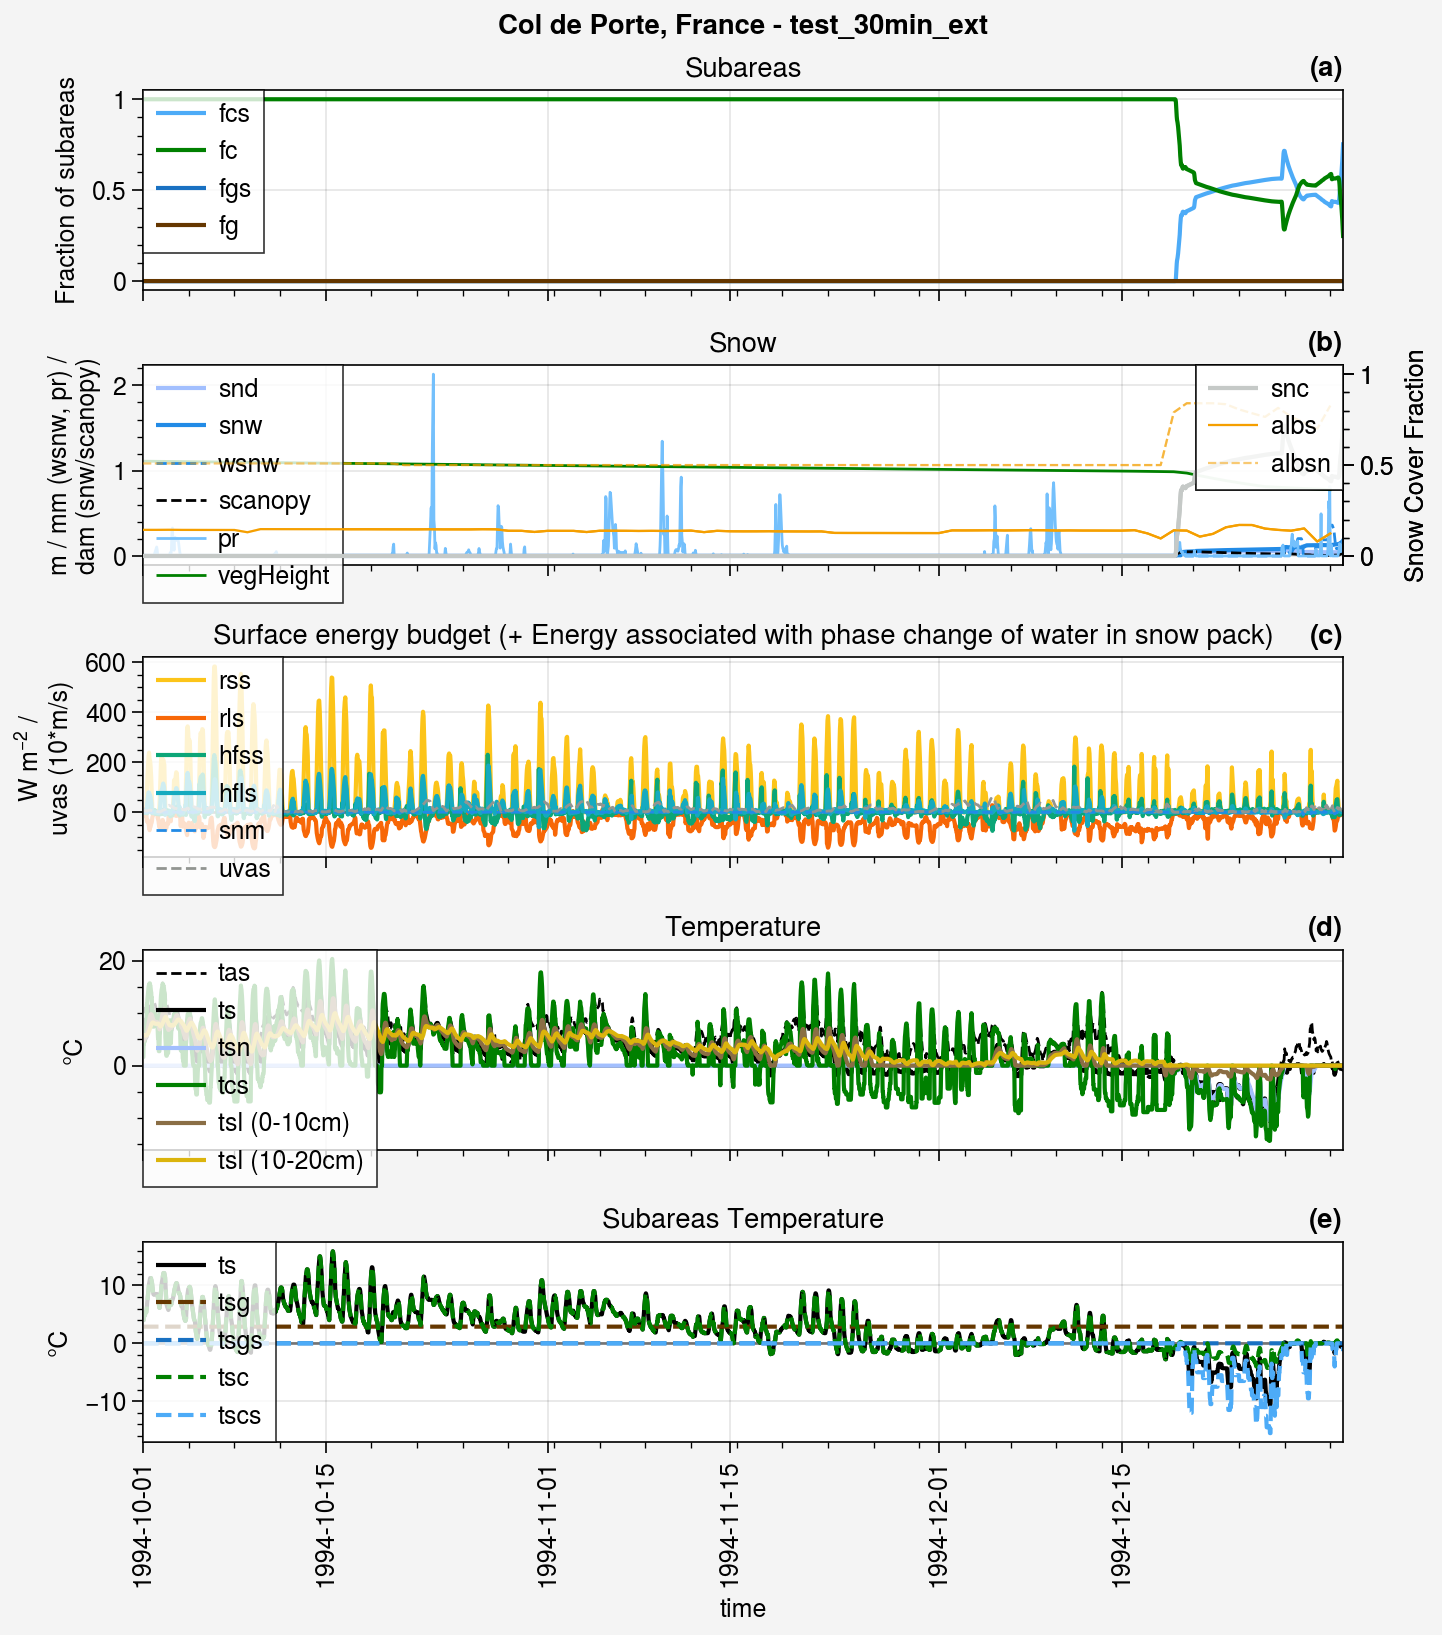

In [7]:
for period in [
    slice(str(y_start)+'-10-01',str(y_start+1)+'-07-30'),
]:

    collabels = labels
    for i, (ds, ds_d) in enumerate(zip(ds_hh_list, ds_d_list)):
        
        fig, axs = pplt.subplots(ncols=1, nrows=5, refaspect=6, refwidth=6, sharey=0)
    
        #############################
        ### Fractions of subareas ###
        #############################

        variables = {
            'fcs': {'color': 'blue4', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fc': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fgs': {'color': 'blue8', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fg': {'color': 'brown', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }

        ax = axs[0]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='Fraction of subareas', title='Subareas', ylim=(-0.05,1.05))

        ##############################
        ### Snow related variables ###
        ##############################

        variables = {
            'snd': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'snw': {'color': 'blue6', 'ls': '-', 'lw': 1.5, 'factor': 1e-3*10, 'shift': 0},
            'wsnw': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'scanopy': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1e-3*10, 'shift': 0},
            'pr': {'color': 'blue3', 'ls': '-', 'lw': 1, 'factor': 500, 'shift': 0},
        #     'albs': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
    #         'mrron': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
        #     'snm': {'color': 'blue8', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
        }

        ax = axs[1]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.plot(ds_d.vegHeight.sel(time=period), label=ds_d.vegHeight.name, color='green', ls='-', lw=1)
        # ax.plot(ds_d.lai.sel(time=period), label='LAI', color='green', ls='-', lw=1)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='m / mm (wsnw, pr) /\ndam (snw/scanopy)', title='Snow')

        variables = {
            'snc': {'color': 'silver', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }
        ox = ax.alty(label='Snow Cover Fraction')
        for key in variables.keys():
            ox.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ox.plot(ds_d.albs.sel(time=period), label='albs', color='yellow7', ls='-', lw=0.8)
        ox.plot(ds_d.albsn.sel(time=period), label='albsn', color='yellow7', ls='--', lw=0.8, alpha=0.5)
        ox.legend(ncols=1, loc='ur')
        ox.format(ylim=(-0.05,1.05))


        ##############################
        ### Surface energy budget ###
        ##############################

        variables = {
            'rss': {'color': 'yellow5', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'rls': {'color': 'orange7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        #     'rlds': {'color': 'orange7', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'hfss': {'color': 'teal7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'hfls': {'color': 'cyan6', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'snm': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'uvas': {'color': 'gray', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
        }

        ax = axs[2]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='W m$^{-2}$ /\nuvas (10*m/s)', title='Surface energy budget (+ Energy associated with phase change of water in snow pack)')


        ###################
        ### Temperature ###
        ###################

        variables = {
            'tas': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 273.15},
            'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},    
            'tsn': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'tcs': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }

        ax = axs[3]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=0), label=ds.tsl.name+' (0-10cm)', color='dirt')
        ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=1), label=ds.tsl.name+' (10-20cm)', color='gold')
        # ax.plot(ds_h_eval_menard2019.ts.sel(time=period), color='red', label='ts obs')
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='°C', title='Temperature')

        


        ############################
        ### Subareas Temperature ###
        ############################

        variables = {
            'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},

            'tsg': {'color': 'brown', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tsgs': {'color': 'blue8', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tsc': {'color': 'green', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tscs': {'color': 'blue4', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
        }

        ax = axs[4]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='°C', title='Subareas Temperature')

        fig.suptitle(site_longname+' - '+collabels[i])
        fig.format(abc='(a)', abcloc='r')
        # fig.save('img/'+labels[i]+'_hh.jpg')

In [8]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
ds_h_met = xr.open_dataset(path_menard2019+'/met_insitu_'+site+'_'+str(y_start)+'_2014.nc').load()
period=slice(str(y_start+1)+'-03-14', str(y_start+1)+'-03-18')

## Compare with obs

In [9]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site+'_'+str(y_start)+'_2014.nc').load()
ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
ds_h_eval_menard2019

<xarray.Dataset> Size: 8MB
Dimensions:   (time: 175320, sdepth: 3)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1994-10-01T01:00:00 ... 2014-10-01
  * sdepth    (sdepth) float32 12B 0.1 0.2 0.5
Data variables:
    albs      (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snd_auto  (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snd_man   (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snw_auto  (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snw_man   (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    ts        (time) float32 701kB 11.12 9.668 8.029 ... 7.532 7.532 8.029
    tsl       (time, sdepth) float32 2MB 11.95 12.28 12.23 ... 12.95 12.83 12.8

## All

Text(0.5, 0.98, 'Col de Porte, France (1994-01-01 - 1994-12-31)')

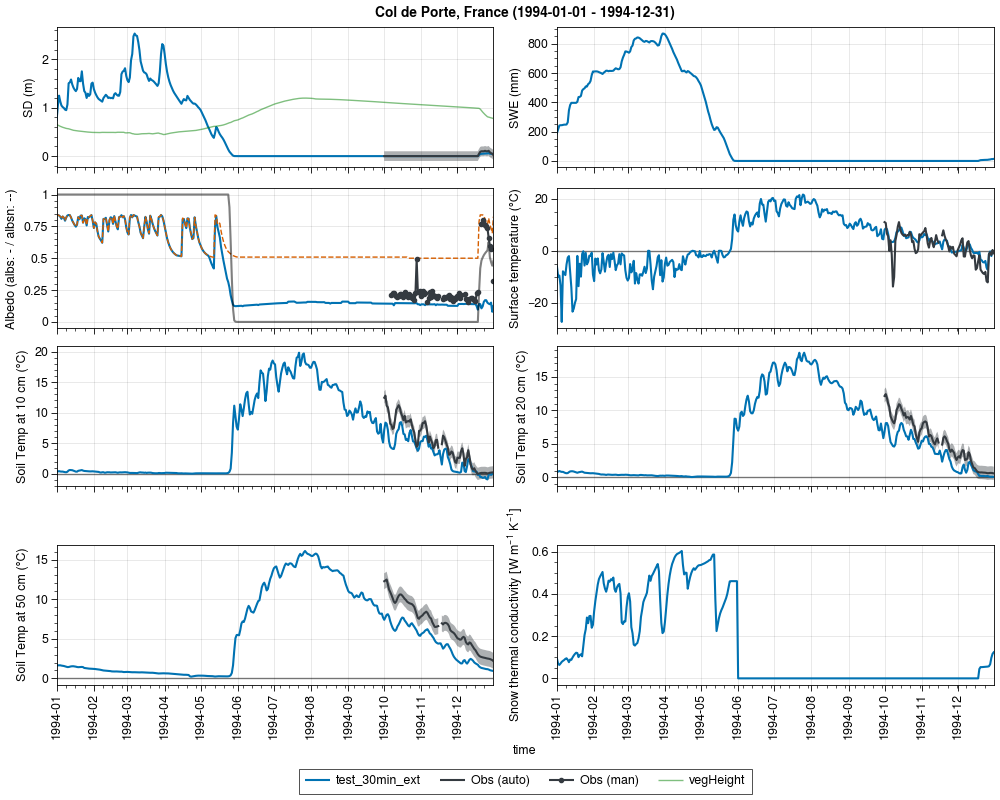

In [10]:
%matplotlib widget
color_obs = 'gray8'
period=slice('1994-01-01', '1994-12-31')

fig, axs = pplt.subplots(nrows=4, ncols=2, refaspect=3.5, sharey=0, figsize=(10,8))

##################
### Snow Depth ###
##################

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snd.sel(time=period), label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_eval_menard2019.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_eval_menard2019.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
axs[0].plot(ds_d_eval_menard2019.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)')
axs[0].plot(ds_d_eval_menard2019.snd_man.sel(time=period), marker='.', color=color_obs, label='Obs (man)')

# Veg
axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', alpha=0.5, lw=1)

fig.legend(loc='b', ncols=5)
axs[0].format(ylabel='SD (m)')

##################
### SWE ###
##################
 # Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snw.sel(time=period), label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values+25, axis=0),
    np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
axs[1].plot(ds_d_eval_menard2019.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
axs[1].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
axs[1].format(ylabel='SWE (mm)')

##################
### Albedo ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[2].plot(ds_d.albs.sel(time=period), label=label+' (albs)')
    axs[2].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', ls='--', lw=1)
    axs[2].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)

# Obs
axs[2].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
axs[2].format(ylabel='Albedo (albs: - / albsn: --)')

##################
### TS ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[3].plot(ds_d.ts.sel(time=period)-273.15, label=label)

# Obs
axs[3].plot(ds_d_eval_menard2019.ts.sel(time=period), color=color_obs)
axs[3].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[3].format(ylabel='Surface temperature (°C)')

##################
### T soil ###
##################
# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[4].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.1)-273.15, label=label)
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
axs[4].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs)

axs[4].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[4].format(ylabel='Soil Temp at 10 cm (°C)')

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[5].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.2)-273.15, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.2)+1, axis=0),
    np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.2)-1, axis=0),), axis=0)
axs[5].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, color=color_obs)

axs[5].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[5].format(ylabel='Soil Temp at 20 cm (°C)')

# Simus
for ds_d, label in zip(ds_d_list, labels):
    axs[6].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.5)-273.15, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.5)+1, axis=0),
    np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.5)-1, axis=0),), axis=0)
axs[6].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, color=color_obs)

axs[6].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
axs[6].format(ylabel='Soil Temp at 50 cm (°C)')

##################
### Snow thermal cond ###
##################

for ds_d, label in zip(ds_d_list, labels):
    axs[7].plot(ds_d.tcsnow.sel(time=period), label=label)
axs[7].format(ylabel='Snow thermal conductivity [W m$^{-1}$ K$^{-1}$]')


fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
# fig.save('img/run_30min_ext_TCZERO_1996_1997.jpg')

In [11]:
ds_hh_list[0]

<xarray.Dataset> Size: 18MB
Dimensions:     (time: 17520, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 140kB 1994-01-01 ... 1994-12-31T23:30:00
  * layer       (layer) float64 160B 0.05 0.15 0.25 0.35 ... 8.9 18.9 41.4 58.9
Data variables: (12/53)
    longitude   float64 8B 5.77
    latitude    float64 8B 45.3
    albs        (time) float64 140kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cdh         (time) float64 140kB 0.000277 0.0003388 ... 0.003429 0.004507
    cdm         (time) float64 140kB 0.0001389 0.0001757 ... 0.001209 0.001668
    evspsblsoi  (time) float64 140kB -1.157e-07 -5.26e-08 ... 5.555e-08 1.02e-07
    ...          ...
    tsgs        (time) float64 140kB 272.2 272.2 272.2 ... 273.2 273.2 273.2
    tsl         (time, layer) float64 3MB 273.2 274.0 274.2 ... 278.9 278.9
    tsn         (time) float64 140kB -1.227 -1.191 -1.156 ... -0.08781 -0.1558
    uvas        (time) float64 140kB 0.7 0.6 0.5 0.5 0.5 ... 0.7 0.7 0.6 0.5 0.6
    wsnw        (time) float64 140kB 0.0 0.0 0.0 0.0 0.0 ... 0.00921 0.0 0.0 0.0
    zpond       (time) float64 140kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20240503 1311
    Conventions:  COARDS
    node_offset:  1
    Comment:       run_test_30min_ext

## Example

In [1]:
def sturm(rho):
    if rho >= 156:
        tc = 3.233e-6 * rho**2 - 1.01e-3*rho + 0.138
    else:
        tc = 0.234e-3*rho + 0.023

    return tc

In [37]:
z1 = 0.1
z2 = 0.1
z3 = 0.2 

rho1 = 600
rho2 = 300
rho3 = 100

tc1 = sturm(rho1)
tc2 = sturm(rho2)
tc3 = sturm(rho3)

In [38]:
rho_tot = (rho1*z1 + rho2*z2 + rho3*z3)/(z1+z2+z3)
tc_tot = sturm(rho_tot)
print('rho_tot = ' + str(rho_tot) +' / tc_tot = ' + str(tc_tot) )

rho_tot = 275.0 / tc_tot = 0.10474562500000001


In [39]:
tc_ave = (z1+z2+z3)/(z1/tc1+z2/tc2+z3/tc3)
tc_ave

0.0762211451401753

In [32]:
z1 = 0.1
z2 = 0.1

rho1 = 500
rho2 = 100

tc1 = sturm(rho1)
tc2 = sturm(rho2)

In [33]:
rho_tot = (rho1*z1 + rho2*z2)/(z1+z2)
tc_tot = sturm(rho_tot)
print('rho_tot = ' + str(rho_tot) +' / tc_tot = ' + str(tc_tot) )

rho_tot = 300.0 / tc_tot = 0.12597000000000003


In [35]:
sturm(rho1)

0.4412499999999999

In [36]:
sturm(rho2)

0.0464

In [37]:
(sturm(rho1)+sturm(rho2))/2

0.24382499999999996

In [34]:
tc_ave = (z1+z2)/(z1/tc1+z2/tc2)
tc_ave

0.08397006049420691

In [12]:
ds_d_tcsnow = (0.234e-3*ds_d.snwdens + 0.023).where(ds_d.snwdens < 156, 
                                               other=3.233e-6 * ds_d.snwdens**2 - 1.01e-3*ds_d.snwdens + 0.138)

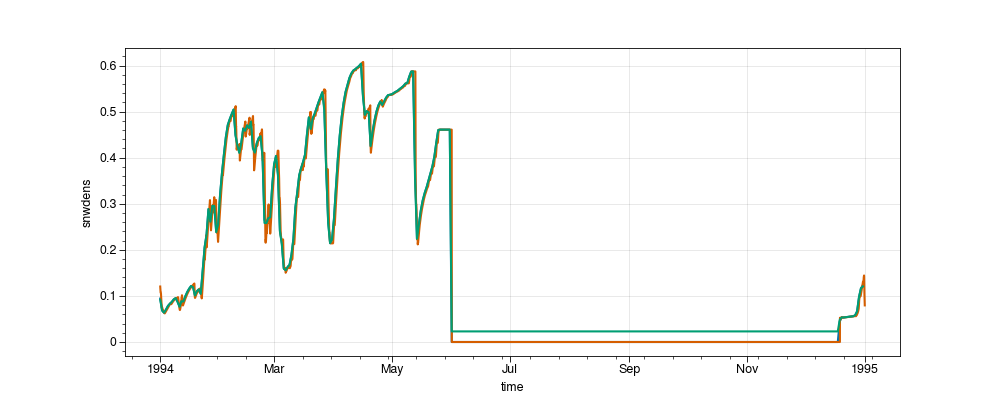

In [13]:
%matplotlib widget
plt.figure(figsize=(10,4))
ds_d.tcsnow.plot()
ds_hh_list[0].tcsnow.plot()
ds_d_tcsnow.plot()
# ds_hh_list[0].tcsnow.resample(time='d').mean().plot()

In [14]:
ds_hh_list[0].tcsnow

<xarray.DataArray 'tcsnow' (time: 17520)> Size: 140kB
array([0.12041467, 0.11868711, 0.11633038, ..., 0.08514076, 0.0824678 ,
       0.07944016])
Coordinates:
  * time     (time) datetime64[ns] 140kB 1994-01-01 ... 1994-12-31T23:30:00
Attributes:
    long_name:   Thermal conductivity of snow
    units:       W m$^{-1}$ K$^{-1}$
    nameInCode:  tcsnow_hh

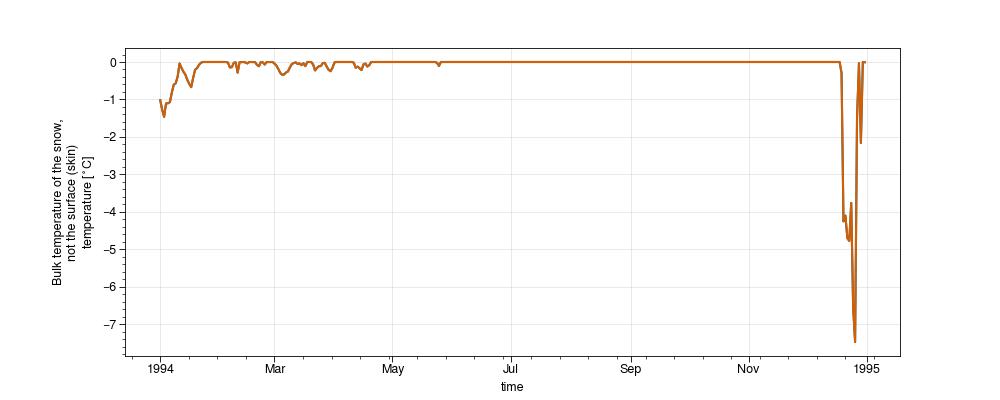

In [18]:
%matplotlib widget
plt.figure(figsize=(10,4))
ds_d.tsn.plot()
# ds_hh_list[0].tsn.plot()
# ds_d_tcsnow.plot()
ds_hh_list[0].tsn.resample(time='d').mean().plot()

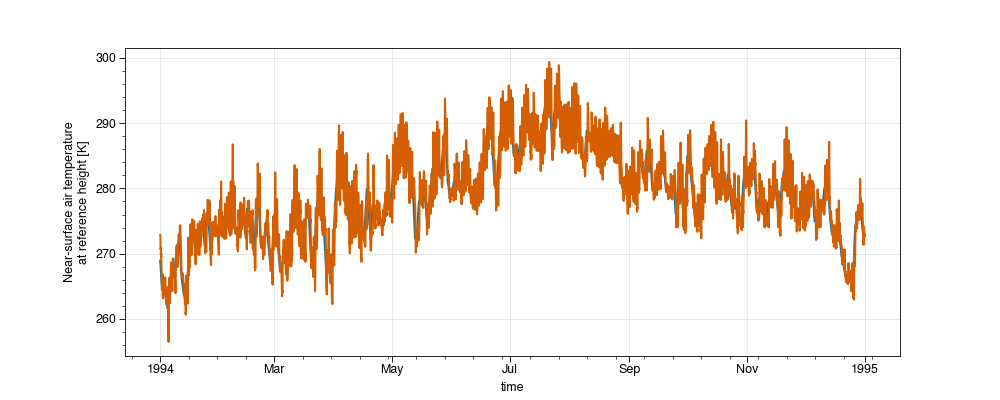

In [33]:
%matplotlib widget
plt.figure(figsize=(10,4))
ds_d.tas.plot()
ds_hh_list[0].tas.plot()
# ds_d_tcsnow.plot()
# ds_hh_list[0].tcsnow.resample(time='d').mean().plot()

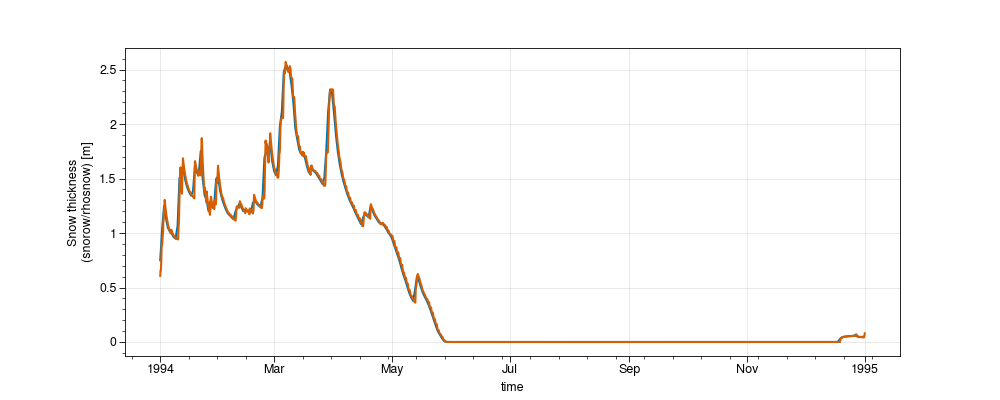

In [19]:
%matplotlib widget
plt.figure(figsize=(10,4))
ds_d.snd.plot()
ds_hh_list[0].snd.plot()
# ds_d_tcsnow.plot()
# ds_hh_list[0].tcsnow.resample(time='d').mean().plot()

In [43]:
ds_hh_list[0].gflx

<xarray.DataArray 'gflx' (time: 122736)> Size: 982kB
array([-6.61798504, -1.01852583, -1.81595836, ...,         nan,
               nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 982kB 1994-01-01 ... 2000-12-31T23:30:00
Attributes:
    long_name:   Heat conduction between soil layers
    units:       W m$^{-2}$
    nameInCode:  gflx_hh

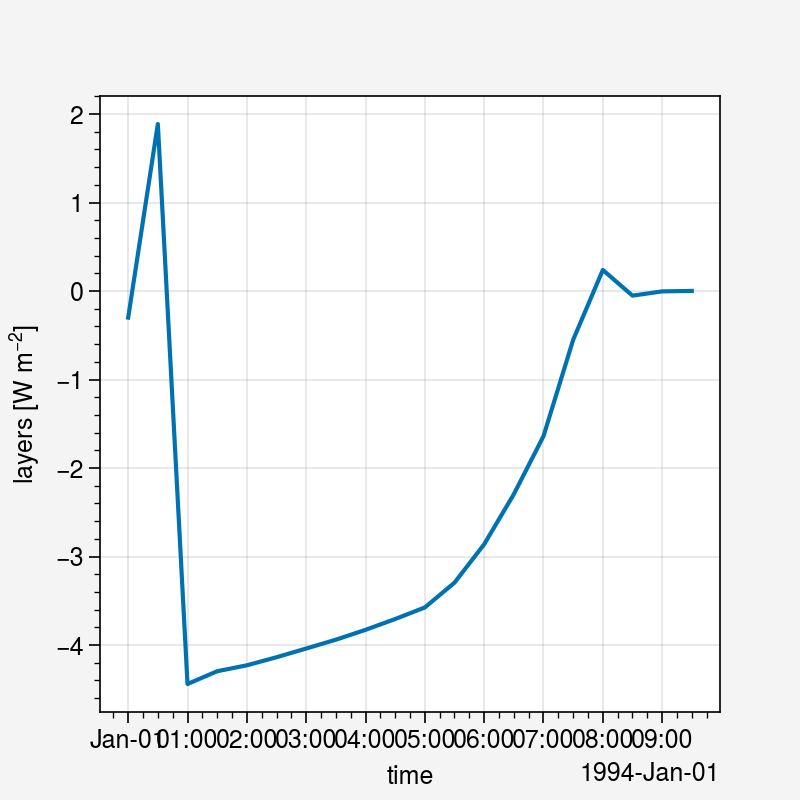

In [17]:
%matplotlib inline
ds_hh_list[0].gflx.plot()